# t-SNE

The aim of this page is to provide a detailed description of the t-SNE algorithm alongside the implementation code which hopefully aids the understanding. The main sources used have been:
- [the original paper](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)
- [this Julia implementation](https://github.com/lejon/TSne.jl) by Leif Jonsson

This is also available as a julia package and can be found at (https://github.com/Wedg/TSNE.jl)

We'll implement and test on the first 5000 images of MNIST.

In [1]:
using MNIST

n = 5000
X = Array{Float64}(784, n)
labels = Array{Int64}(n)
for i = 1:n
    X[:, i] = trainfeatures(i) ./ 255
    labels[i] = trainlabel(i)
end

## 1. Overview

The method of t-SNE (t-Distributed  Stochastic Neigbour Embedding) (van der Maaten and Hinton, 2008) is to define a joint distribution over the data points in the original high-dimension space, and then map that to an equivalent distribution in low-dimension space (e.g. 2 or 3 dimensions) by minimising the KL divergence between the two distributions.

I.e., given the initial data in high-dimension space - $n$ observations ($x_1, x_2, \dots, x_n$) where each vector $x_i$ has a high number of dimensions:  

1. Create the pairwise similarity matrix $P$ from the high dimension space where $P_{ij}$ is the pairwise similarity of $x_i$ and $x_j$.
2. Create the pairwise similarity matrix $Q$ from the low dimension space where $Q_{ij}$ is the pairwise similarity of $y_i$ and $y_j$.
3. Run an optimisation to learn the $y$ values by using KL divergence $KL(P \mid \mid Q)$ to get $Q$ to approximate $P$.

## 2. P Matrix

### 2.1 Conditional P
t-SNE contructs the joint distribution by initially constructing a conditional distribution as follows:

$$
p_{i \mid j} = \frac{\exp{\left(-\|x_i - x_j\|^2 \, / \, 2\sigma_j^2 \right)}}
                    {\sum_{k \neq j}\exp{\left(-\| x_k - x_j \|^2 \, / \, 2\sigma_j^2 \right)}}
$$

In the words of the original paper - "The similarity of datapoint $x_i$ to datapoint $x_j$ is the conditional probability, $p_{i \mid j}$, that $x_j$ would pick $x_i$ as its neighbour if neighbours were picked in proportion to their probability density under a Gaussian centered at $x_j$."

$p_{i \mid i}$ is set to zero as we are only interested in pairwise similarity. $\sigma_j$ is the variance of the Gaussian centred on datapoint $x_j$. We'll need a method to determine a "good" value of each $\sigma_j$. This is covered below.

Side note - I've swapped around the indices from the original paper becuase Julia is column major so it's more efficient to sum over columns than rows. I'm going to follow the convention for the matrices that $i$ refers to row and $j$ to column.

### 2.1.1 Distance
The first useful function to write is the distance matrix $D$ containing the pairwise squared Euclidean distances. Each element is
$$
D_{ij} = \|x_i - x_j\|^2
$$

Using the Distances.jl package this is equivalent to - `pairwise(SqEuclidean(), X)`

In [2]:
function pairwise_sq_euc_dist(X::AbstractMatrix{F}, diagval::F) where {F<:AbstractFloat}
    n = size(X, 2)
    s = sum(abs2, X, 1)                # sᵢ = ||xᵢ||²
    D = BLAS.syrk('L', 'T', F(-2), X)  # Computes lower triangle of D = - 2 .* (X' * X)
    
    # Complete the full distance matrix: D = - 2 .* (X' * X) .+ s .+ s'
    for j in 1:n
        
        for i in 1:(j - 1)  # Upper triangle - copy from lower triangle (matrix is symmetric)
            D[i, j] = D[j, i]
        end
        
        # Diagonal - often 0, but can use for tricks e.g. set to -Inf to underflow to 0 under exp or inv
        D[j, j] = diagval
        
        sj = s[j]
        for i in (j + 1):n  # Lower triangle
            D[i, j] += (s[i] + sj)
        end
    end
    
    return D
end;

### 2.1.2 Perplexity

Because the density of the data set is likely to vary, it is unlikely that a single $\sigma$ will work for all points. E.g. in dense regions a small value of $\sigma$ is apropriate, in sparse regions a large value of $\sigma$ is appropriate.

The method used to find an appropriate $\sigma_j$ for each point $j$ is for the user to specify a perplexity. Perplexity is defined as

$$
Perp(P_j) = 2^{H(P_j)}
$$

where $H(P_i)$ is the Shannon entropy measure of $P_j$ measured in bits i.e. 
$$
H(P_j) = - \sum_j p_{i \mid j} \log_2 p_{i \mid j}
$$

A binary search is used to find the $\sigma_j$ that corresponds to the specified perplexity. This is done in the `conditional_p` function below.

With $\beta_j \equiv \frac{1}{2 \sigma_j^2}$ and $D_{ij} = \|x_i - x_j\|^2$ as well as some pencil, paper and a little head scratching you can confirm that  
$$
H_j = - \sum_j p_{i \mid j} \log_2 p_{i \mid j} 
    = \left( \frac{\beta_j \sum_i D_{ij} \, \exp(- \beta_j  \, D_{ij})}{\sum_{k \neq j} \exp(- \beta_j  \, D_{kj})} 
      + \log \left( \textstyle \sum_{k \neq j} \exp(- \beta_j  \, D_{kj} \right) \right) \, \frac{1}{\log(2)}
$$

This makes it possible to calculate both the vector $P_j$ and the value $H_j$ in one pass.

The **`entropy_and_conditional_p!`** function calculates the entropy of the distribution around point $j$ as well as the conditional probability of each point $p_{i \mid j}$ given $D_j$ and $\beta_j$. $P_j$ is changed in-place and $H_j$ is returned.

In [3]:
function entropy_and_conditional_p!(Pj::AbstractVector{F}, Dj::AbstractVector{F}, 
                                    βj::F) where {F<:AbstractFloat} 
    sumPj, dotDjPj = F(0), F(0)
    for i in eachindex(Pj)
        sumPj += (Pj[i] = exp(-βj * Dj[i]))
        dotDjPj += Dj[i] * Pj[i]
    end
    Hj = (βj * dotDjPj / sumPj + log(sumPj)) / log(F(2))
    Pj ./= sumPj
    return Hj
end;

### 2.1.3 Stability

`reducemin!` is a helper function for reducing each vector by it's minimum. Because each element of $D$ and each $\beta$ are positive, $- \beta_j D_{ij}$ is negative, and the reducemin on a column of $D$ has the effect of moving the range of $- \beta_j D_{ij}$ to $(-\infty, 0)$.

This is valid for use in the definition of $p_{i \mid j}$ since 
$$
\dfrac{\exp(z_i)}{\sum_i \exp(z_i)} = \dfrac{\exp(z_i + c)}{\sum_i \exp(z_i + c)}.
$$ 

You'll probably recognise this move from using the softmax function as a prediction function. In this case it isn't as necessary as the inputs to the exponent function are already negative - this just guarantees that not all exponents will underflow to zero.

In [4]:
function reducemin!(Dj)
    minDj = minimum(Dj)
    for i in eachindex(Dj)
        Dj[i] -= minDj
    end
end;

### 2.1.4 Binary search for $\sigma_j$ and calculating conditional P

`conditional_p` performs, for each column (point $j$), a binary search for the value $\beta_j = \frac{1}{2 \sigma_j^2}$ and returns the matrix of conditional probabilities $p_{i \mid j}$. Each column sums to $1$ i.e. $\sum_i p_{i \mid j} = 1$.

In [5]:
function conditional_p(D::AbstractMatrix{F}, perplexity::F, tol::F, 
                       max_iter::T) where {T<:Integer, F<:AbstractFloat}
    
    # Number of observations - columns of X
    n = size(D, 1)
    
    # Initialise P matrix and β vector
    P = zeros(F, n, n)
    β = zeros(F, n)
    
    # Initialise column vectors
    Dj = zeros(F, n)
    Pj = zeros(F, n)
    
    # Binary search target
    target = log2(perplexity)
    
    # Binary search over each column
    for j in 1:n
        
        # Re-initialise column vectors
        fill!(Pj, F(0))
        copy!(Dj, view(D, :, j))
        
        # Subtract minimum value for better stability
        reducemin!(Dj)
        
        # Initial binary search values
        βj_min = F(0)
        βj_max = F(Inf)
        βj = F(1)
        
        # Binary search loop
        for iter in 1:max_iter

            # Calculate conditional probabilities and entropy given βj
            Hj = entropy_and_conditional_p!(Pj, Dj, βj)

            # Break from loop if within tolerence
            abs(target - Hj) < tol && break

            # Search branches
            if target < Hj
                βj_min = βj
                βj = isinf(βj_max) ? 2βj : (βj_min + βj_max) / 2
            else
                βj_max = βj
                βj = (βj_min + βj_max) / 2
            end
            
            # Warn if max iterations reached
            iter == max_iter && warn("Max iterations reached for column $j with perplexity = $(2^Hj)")
        end

        # Save the results
        P[:, j] = Pj
        β[j] = βj
    end
    
    # Return conditional probabilities
    return P
end;

### 2.2 Joint P

The joint probabilities are defined as the symmetrised conditional probabilities  

$$
p_{ij} = \frac{p_{i \mid j} + p_{j \mid i}}{2n}
$$.

The original SNE (Hinton and Roweiss, 2002) method minimised the KL divergence over the assymmetric conditional probabilities. Using a symmetric $P$ is called Symmetric SNE. And defining $p_{ij}$ as above ensures that $\sum_i p_{ij} > \frac{1}{2n}$ and therefore each data point - even outliers - contributes to the cost function.

`joint_p!` replaces the conditional $P$ matrix in-place with the joint $P$ matrix.

In [6]:
function joint_p!(P::AbstractMatrix{F}) where {F<:AbstractFloat}
    n = size(P, 2)
    for j = 1:n
        for i = (j + 1):n  # Lower triangle
            P[i, j] += P[j, i]
            P[j, i] = P[i, j]
        end
    end
    scale!(P, F(inv(2n)))
end;

### 2.3 Putting P together
Steps in `create_P` are:
- Create distance matrix $D$
- Create matrix of conditional probabilities $p_{i \mid j}$ using binary search for parameter $\sigma_j$
- Create matrix of joint probabilities $p_{ij}$

In [7]:
function create_P(X::AbstractMatrix{F}, perplexity::F, tol::F, max_iter::T) where {T<:Integer, F<:AbstractFloat}
    D = pairwise_sq_euc_dist(X,  prevfloat(F(Inf)))
    P = conditional_p(D, perplexity, tol, max_iter)
    joint_p!(P)
    return P
end;

## 3. Q Matrix

In t-SNE the pairwise similarities in the low dimension map are given by

$$
q_{ij} = \frac{\left(1 + \|y_i - y_j\|^2 \right)^{-1}}
              {\sum_{k} \sum_{l \neq k} \left(1 + \| y_k - y_l \|^2 \right)^{-1}}
$$

i.e. a Student t-distribution with one degree of freedom (same as a Cauchy distribution). The original SNE method used a Gaussian in the low dimension space. One nice property of this defintion is that $(1 + \|y_i - y_j\|^2 )^{-1}$ 
approaches an inverse square law for large pairwise distances. This makes it robust to changes in scale. There is also the computational benefit that it is faster to evaluate than the Gaussian because it doesn't have the exponential function.

For computation reasons (that should make sense when looking at the gradient function below) `joint_q!` doesn't return the full $Q$ matrix but instead returns the matrix of the numerators $(1 + \|y_i - y_j\|^2 )^{-1}$ - called `Qtop` - and separately the denominator $\sum_{k} \sum_{l \neq k} \left(1 + \| y_k - y_l \|^2 \right)^{-1}$ - called `sumQ` - which is identical for all $Q_{ij}$.

In [8]:
function joint_q!(Qtop::AbstractMatrix{F}, s::AbstractMatrix{F}, 
                  Y::AbstractMatrix{F}) where {F<:AbstractFloat}
    n = size(Qtop, 2)
    sum!(abs2, s, Y)                            # sᵢ = ||Yᵢ||² (in-place)
    BLAS.syrk!('L', 'T', F(-2), Y, F(0), Qtop)  # Lower triangle of Qtop = - 2 .* (Y' * Y) (in-place)
    
    sumQ = zero(F)
    @inbounds for j = 1:n
        Qtop[j, j] = F(0)  # Diagonal = 0
        sj = s[j]
        @simd for i = (j + 1):n  # Lower triangle
            Qtop[i, j] += (s[i] + sj)
            sumQ += (Qtop[i, j] = inv(one(F) + Qtop[i, j]))
        end
    end
    sumQ = 2 * sumQ
end;

## 4. Cost

The cost function is the KL divergence between $P$ and $Q$ i.e.
$$
C = KL(P \mid \mid Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

A regularisation technique used by van der Maaten is what they call "early exaggeration". All the $p_{ij}$'s are multiplied by a constant in the initial stages of optimisation. All the $q_{ij}$'s still sum to $1$ are much too small to model the $p_{ij}$'s and the model is encouraged to model the large $p_[ij]$'s with large $q_[ij]$'s and this results in the natural clusters forming tight and widely seperated clusters in the map $y$. 

In the implementation below note that:
- Because both $P$ and $Q$ are symmetric we can loop through just the lower triangle and then double the result.
- We're actually looping over `Qtop` (defined above in `joint_q`) instead of $Q$.
- Both the denominator of the Q matrix (`sumQ`) and the early exaggeration paramater (`exagg`) are constant so can modify the final result (i.e. don't need to be in the inner loop calculation).

In [9]:
function kl_div(P::AbstractMatrix{F}, Qtop::AbstractMatrix{F}, sumQ::F, exag::F) where {F<:AbstractFloat}
    n = size(P, 2)
    cost = zero(F)
    for j = 1:n
        for i = (j + 1):n  # Lower triangle
            @inbounds cost += P[i, j] * log(P[i, j] / Qtop[i, j])
        end
    end
    return (2 * cost) / exag + log(sumQ / exag)
end;

## 5. Gradients

The gradients of each parameter $y_{dj}$ are (the paper has the derivation):

$$
\frac{\partial C}{\partial y_{dj}} = 4 \sum_i (p_{ij} - q_{ij}) \, (1 + \mid\mid y_i - y_j \mid\mid^2)^{-1} \, (y_{di} - y_{dj})
$$

In [10]:
function grad!(ΔY::AbstractMatrix{F}, Y::AbstractMatrix{F}, P::AbstractMatrix{F}, 
               Qtop::AbstractMatrix{F}, sumQ::F)  where {F<:AbstractFloat}
    fill!(ΔY, zero(F))
    invsumQ = inv(sumQ)
    n = size(P, 2)
    for j in 1:n
        for i = (j+1):n  # Lower Triangle
            @inbounds tmp1 = 4 * (P[i, j] - Qtop[i, j] * invsumQ) * Qtop[i, j]
            for d in indices(ΔY, 1)
                tmp2 = tmp1 * (Y[d, j] - Y[d, i])
                ΔY[d, j] += tmp2
                ΔY[d, i] -= tmp2
            end
        end
    end
end;

### 5.1 Always a good idea to test the gradients

In [11]:
function check_gradients(X, d)
    
    # Number of observations
    n = size(X, 2)
    
    # Create P Matrix
    P = create_P(X, 30.0, 1e-5, 50)
    
    # Initialise Y matrix - sample from Normal(0, 1e-4)
    Y = randn(d, n) * 1e-4
    
    # Initialise re-use matrices
    s, Qtop, ΔY = zeros(1, n), zeros(n, n), zeros(d, n)
    
    # Calculate gradients analytically
    sumQ = joint_q!(Qtop, s, Y)
    grad!(ΔY, Y, P, Qtop, sumQ)
    
    # Size of perturbation
    ϵ = 1e-5
    
    # Initialise numeric gradient array
    numeric_grad = zeros(ΔY)
    
    # Estimate gradient for each parameter separately
    for i in eachindex(Y)

        # Store value of parameter
        tmp = Y[i]

        # Forward
        Y[i] += ϵ
        sumQ = joint_q!(Qtop, s, Y)
        cost1 = kl_div(P, Qtop, sumQ, 1.0)
        
        # Backward
        Y[i] -= 2ϵ
        sumQ = joint_q!(Qtop, s, Y)
        cost2 = kl_div(P, Qtop, sumQ, 1.0)

        # Calculate numeric gradient using central difference
        numeric_grad[i] = (cost1 - cost2) ./ 2ϵ

        # Reset the parameter
        Y[i] = tmp
    end
    
    # Display results
    # Display the difference between numeric and analytic gradient for each parameter
    @printf "\e[1m%s\e[0m" " Numeric Gradient    Analytic Gradient           Difference\n"
    for i=1:min(15, length(numeric_grad))
        @printf "%17e %20e %20e \n" numeric_grad[i] ΔY[i] numeric_grad[i] - ΔY[i]
    end
    @printf "%17s %20s %20s \n\n" "..." "..." "..."
    @printf "\e[1m%s\e[0m" " Largest differences:\n"
    @printf "%17e %20e \n" extrema(numeric_grad .- ΔY)...
end;

In [12]:
check_gradients(X[:, 1:40], 3)

 Numeric Gradient    Analytic Gradient           Difference
     6.635137e-07         6.634913e-07         2.234492e-11 
     1.621903e-06         1.621881e-06         2.176541e-11 
    -6.403322e-07        -6.403317e-07        -5.585587e-13 
     1.884981e-06         1.885007e-06        -2.550963e-11 
    -4.586109e-07        -4.585938e-07        -1.711631e-11 
    -1.337108e-06        -1.337095e-06        -1.369592e-11 
    -4.476242e-06        -4.476238e-06        -3.804300e-12 
    -1.866507e-06        -1.866517e-06         1.020692e-11 
     8.129497e-07         8.129543e-07        -4.570998e-12 
     1.926770e-06         1.926796e-06        -2.595548e-11 
     5.507594e-07         5.508231e-07        -6.367125e-11 
     2.261480e-06         2.261496e-06        -1.638406e-11 
    -1.871392e-07        -1.871356e-07        -3.609141e-12 
    -1.960432e-06        -1.960405e-06        -2.672284e-11 
    -3.105960e-07        -3.105795e-07        -1.644843e-11 
              ...        

## 6. PCA
In the t-SNE paper van der Maaten reduces the number of dimensions using PCA before applying t-SNE. This speeds up the computation of pairwise distances - and hopefully doesn't distort the pairwise distances.

In [13]:
function pca(X, k)
    Σ = X * X' ./ size(X, 1)         # Covariance natrix
    F = svdfact(Σ)                   # Factorise into Σ = U * diagm(S) * V'
    Xrot = F.U' * X                  # Rotate onto the basis defined by U
    pvar = sum(F.S[1:k]) / sum(F.S)  # Percentage of variance retained with top k vectors
    X̃ = Xrot[1:k, :]                 # Keep top k vectors
    return X̃, pvar
end;

## 7. Gradient Descent

For the gradient descent optimisation van der Maaten uses both momentum and adaptive learning. 

In [14]:
function update!(Y::AbstractArray{F}, Yμ::AbstractArray{F}, ∇Y::AbstractArray{F}, 
                 Yg::AbstractArray{F}, μ::F, η::F, min_gain::F) where {F<:AbstractFloat}
    for i in eachindex(Y)
        
        # Update gains - adaptive learning params
        ∇Y[i] * Yμ[i] > 0 ? Yg[i] = max(Yg[i] * 0.8, min_gain) : Yg[i] += 0.2
        
        # Momentum gradient descent update with adaptive learning
        Yμ[i] = μ * Yμ[i] - η * Yg[i] * ∇Y[i]
        Y[i] += Yμ[i]
    end
end;

`t()` is for displaying the time during the gradient descent optimisation.

In [15]:
# Time
t() = Dates.format(now(), "HH:MM:SS");

## 8. t-SNE

Finally here is the main function that brings this all together.

In [16]:
"""
    tsne(X, d, [perplexity = 30.0, perplexity_tol = 1e-5, perplexity_max_iter = 50, 
                pca_init = true, pca_dims = 30, exag = 12.0, stop_exag = 250, 
                μ_init = 0.5, μ_final = 0.8, μ_switch = 250, 
                η = 100.0, min_gain = 0.01, num_iter = 1000])

### Input types
- `F::AbstractFloat`
- `T::Integer`

### Arguments
- `X::Matrix{F}`: Data matrix - where each row is a feature and each column is an observation / point
- `d::T`: The number of dimensions to reduce X to (e.g. 2 or 3)

### Keyword arguments and default values
- `perplexity::F = 30.0`: User specified perplexity for each conditional distribution
- `perplexity_tol::F = 1e-5`: Tolerence for binary search of bandwidth
- `perplexity_max_iter::T = 50`: Maximum number of iterations used in binary search for bandwidth
- `pca_init::Bool = true`: Choose whether to perform PCA before running t-SNE
- `pca_dims::T = 30`: Number of dimensions to reduce to using PCA before applying t-SNE
- `exag::T = 12`: Early exaggeration - multiply all p_ij's by this constant
- `stop_exag::T = 250`: Stop the early exaggeration after this many iterations
- `μ_init::F = 0.5`: Initial momentum parameter
- `μ_final::F = 0.8`: Final momentum parameter
- `μ_switch::T = 250`: Switch from initial to final momentum parameter at this iteration
- `η::F = 100.0`: Learning rate
- `min_gain::F = 0.01`: Minimum gain for adaptive learning
- `num_iter::T = 1000`: Number of iterations
- `show_every::T = 100`: Display progress at intervals of this number of iterations
"""
function tsne(X::AbstractMatrix{F}, d::T; 
              perplexity::F = 30.0, perplexity_tol::F = 1e-5, perplexity_max_iter::T = 50,
              pca_init::Bool = true, pca_dims::T = 30, 
              exag::F = 12.0, stop_exag::T = 250, 
              μ_init::F = 0.5, μ_final::F = 0.8, μ_switch::T = 250, 
              η::F = 100.0, min_gain::F = 0.01, num_iter::T = 1000, 
              show_every::T = 100) where {T<:Integer, F<:AbstractFloat}
    
    # Number of observations
    n = size(X, 2)
    
    # Run PCA
    if pca_init
        print(t())
        @printf(" Running PCA ...")
        X, pvar = pca(X, pca_dims)
        @printf(" completed ... percentage of variance retained = %.1f%%\n", pvar*100)
    end
    
    # Create P Matrix
    print(t())
    @printf(" Computing high dimension joint probabilities ...")
    P = create_P(X, perplexity, perplexity_tol, perplexity_max_iter)
    @printf(" completed\n\n")
    scale!(P, exag)             # early exaggeration
    
    # Initialise matrices
    Y = randn(F, d, n) * 1e-4   # low dimension map - initialise by sampling from Normal(0, 1e-4)
    s = zeros(F, 1, n)          # sum(abs2, Y, 1)
    Qtop = zeros(F, n, n)       # ||Yⱼ - Yⱼ||² etc
    ∇Y = zeros(F, d, n)         # gradient of Y
    Yμ = zeros(F, d, n)         # velocity of Y - momentum gradient descent
    Yg = ones(F, d, n)          # gains of Y - adaptive learning rate params
    
    # Initial momentum
    μ = μ_init
    
    # Gradient descent updates
    println("Running gradient descent updates ...")
    for iter in 1:num_iter

        # Calculate Q probabilities
        sumQ = joint_q!(Qtop, s, Y)
        
        # Calculate gradients
        grad!(∇Y, Y, P, Qtop, sumQ)
        
        # Update Y
        update!(Y, Yμ, ∇Y, Yg, μ, η, min_gain)
        
        # Show progress
        if mod(iter, show_every) == 0
            # print progress
            cost = kl_div(P, Qtop, sumQ, exag)
            print(t())
            @printf(" Iteration %d: cost = %.5f, gradient norm = %.5f\n", iter, cost, norm(∇Y))
        end
        
        # Change momentum param after μ_switch iterations
        iter == μ_switch && (μ = μ_final)
        
        # Stop exaggeration
        if iter == stop_exag
            scale!(P, inv(exag))
            exag = F(1)
        end
    end
    
    # Completed results
    return Y
end;

In [17]:
?tsne

search: istaskdone getsockname gethostname CartesianIndex broadcast_setindex!



```
tsne(X, d, [perplexity = 30.0, perplexity_tol = 1e-5, perplexity_max_iter = 50, 
            pca_init = true, pca_dims = 30, exag = 12.0, stop_exag = 250, 
            μ_init = 0.5, μ_final = 0.8, μ_switch = 250, 
            η = 100.0, min_gain = 0.01, num_iter = 1000])
```

### Input types

  * `F::AbstractFloat`
  * `T::Integer`

### Arguments

  * `X::Matrix{F}`: Data matrix - where each row is a feature and each column is an observation / point
  * `d::T`: The number of dimensions to reduce X to (e.g. 2 or 3)

### Keyword arguments and default values

  * `perplexity::F = 30.0`: User specified perplexity for each conditional distribution
  * `perplexity_tol::F = 1e-5`: Tolerence for binary search of bandwidth
  * `perplexity_max_iter::T = 50`: Maximum number of iterations used in binary search for bandwidth
  * `pca_init::Bool = true`: Choose whether to perform PCA before running t-SNE
  * `pca_dims::T = 30`: Number of dimensions to reduce to using PCA before applying t-SNE
  * `exag::T = 12`: Early exaggeration - multiply all p_ij's by this constant
  * `stop_exag::T = 250`: Stop the early exaggeration after this many iterations
  * `μ_init::F = 0.5`: Initial momentum parameter
  * `μ_final::F = 0.8`: Final momentum parameter
  * `μ_switch::T = 250`: Switch from initial to final momentum parameter at this iteration
  * `η::F = 100.0`: Learning rate
  * `min_gain::F = 0.01`: Minimum gain for adaptive learning
  * `num_iter::T = 1000`: Number of iterations
  * `show_every::T = 100`: Display progress at intervals of this number of iterations


## 9. Test t-SNE on MNIST

In [18]:
Y = tsne(X, 2, perplexity=40.0);

15:33:10 Running PCA ... completed ... percentage of variance retained = 84.1%
15:33:11 Computing high dimension joint probabilities ... completed

Running gradient descent updates ...
15:34:21 Iteration 100: cost = 4.25723, gradient norm = 0.00415
15:34:54 Iteration 200: cost = 4.10153, gradient norm = 0.00003
15:35:28 Iteration 300: cost = 2.11813, gradient norm = 0.00106
15:36:01 Iteration 400: cost = 1.58122, gradient norm = 0.00030
15:36:33 Iteration 500: cost = 1.42206, gradient norm = 0.00015
15:37:07 Iteration 600: cost = 1.34521, gradient norm = 0.00010
15:37:44 Iteration 700: cost = 1.30139, gradient norm = 0.00007
15:38:19 Iteration 800: cost = 1.27363, gradient norm = 0.00005
15:38:54 Iteration 900: cost = 1.25441, gradient norm = 0.00005
15:39:31 Iteration 1000: cost = 1.24109, gradient norm = 0.00004


Now we can plot. I'll use Gadfly.

In [20]:
using Gadfly, Colors
set_default_plot_size(24cm, 18cm)

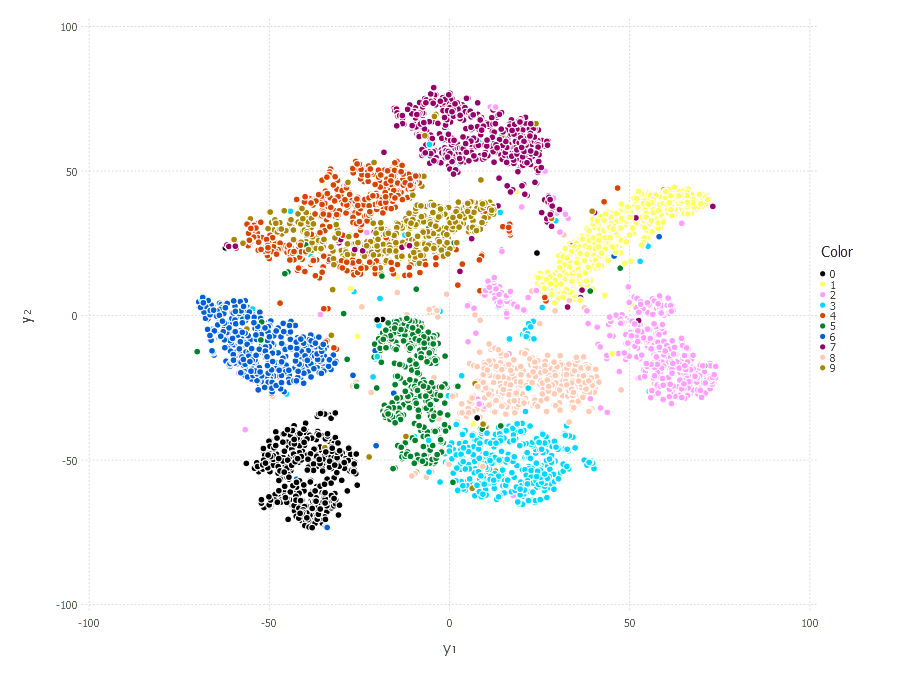

In [21]:
palette = distinguishable_colors(10)
p = plot(x=Y[1, :], y=Y[2, :], color=labels, Geom.point, Guide.xlabel("y₁"), Guide.ylabel("y₂"), 
         Scale.color_discrete_manual(palette..., levels=collect(0:9)), Theme(colorkey_swatch_shape=:circle))

And a reduction to 3D:

In [22]:
Y = tsne(X, 3, perplexity=40.0);

15:49:42 Running PCA ... completed ... percentage of variance retained = 84.1%
15:49:43 Computing high dimension joint probabilities ... completed

Running gradient descent updates ...
15:51:06 Iteration 100: cost = 4.14741, gradient norm = 0.00094
15:51:48 Iteration 200: cost = 4.07816, gradient norm = 0.00011
15:52:28 Iteration 300: cost = 1.89365, gradient norm = 0.00084
15:53:11 Iteration 400: cost = 1.41784, gradient norm = 0.00023
15:53:52 Iteration 500: cost = 1.28021, gradient norm = 0.00012
15:54:36 Iteration 600: cost = 1.21468, gradient norm = 0.00008
15:55:21 Iteration 700: cost = 1.17650, gradient norm = 0.00006
15:56:05 Iteration 800: cost = 1.15224, gradient norm = 0.00004
15:56:50 Iteration 900: cost = 1.13541, gradient norm = 0.00003
15:57:34 Iteration 1000: cost = 1.12320, gradient norm = 0.00003


Save the files using JLD for visualising later using a package like GLVisualize.

In [24]:
using JLD

In [25]:
save("tsne3d.jld", "X", X, "labels", labels, "Y", Y)